In [2]:
import pickle
import xarray as xr
import pandas as pd
import scipy.stats as stats
import numpy
import matplotlib.pyplot as plt

Here we evaluate the robustness of each of the 6 atmospheric inversion models to the Global Carbon Project observations.<br><br>
Note that GCP land flux = land (from DGVMs) + BIM (budget imbalance) which represents the residual flux. This keeps the analysis consistent with comparing models to observations (GCP).

In [3]:
# Models
CAMS = pd.read_csv("./../Output/output_raw/output_CAMS.csv").set_index("Year")
CTRACKER = pd.read_csv("./../Output/output_raw/output_CTRACKER.csv").set_index("Year")
Rayner = pd.read_csv("./../Output/output_raw/output_Rayner.csv").set_index("Year")
JAMSTEC = pd.read_csv("./../Output/output_raw/output_JAMSTEC.csv").set_index("Year")
JENA_s76 = pd.read_csv("./../Output/output_raw/output_JENA_s76.csv").set_index("Year")
JENA_s85 = pd.read_csv("./../Output/output_raw/output_JENA_s85.csv").set_index("Year")

In [4]:
#GCP
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
df.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,0.852376,0.516073,0.860316
1960,0.819017,1.394030,0.522722
1961,0.714842,0.605098,1.213762
1962,0.756709,1.348349,0.959605
1963,0.904997,0.877794,1.355333


In [5]:
fCO2 = './../co2_temp_data/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col=0)[2:]
CO2.head()

,CO2
Year,
1959,315.486
1960,316.163
1961,316.856
1962,317.558
1963,318.268


In [6]:
df['CO2'] = CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']
df['budget imbalance'] = -df["budget imbalance"]+df['land sink']

df.head()

,ocean sink,land sink,budget imbalance,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [7]:
df.rename(columns={"ocean sink": "ocean", "land sink": "land (model)", "budget imbalance": "land"},
         inplace=True)
df.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


# Plots

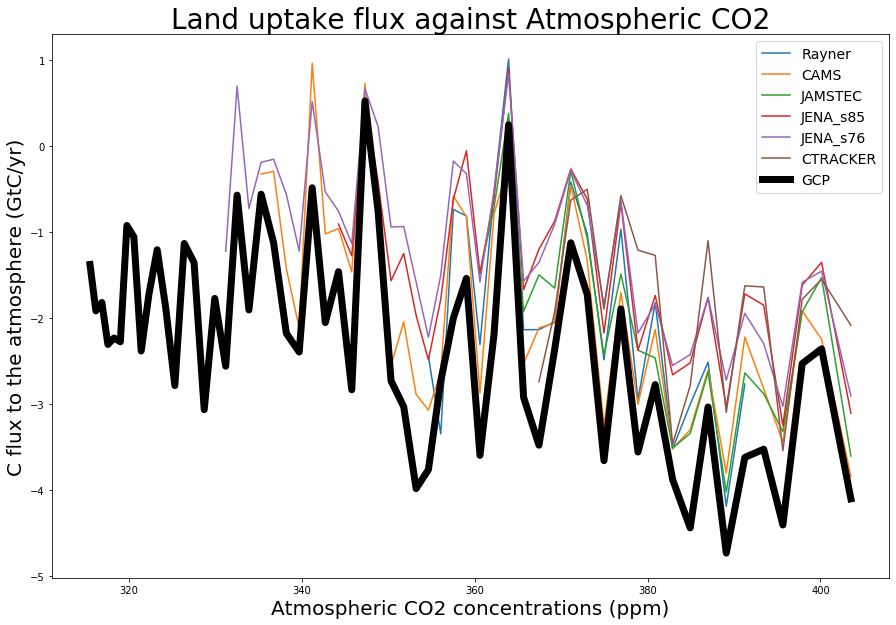

In [8]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Land)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Land)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Land)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Land)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Land)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Land)
plt.plot(df.CO2, df.land, linewidth=7, color='k')

plt.title("Land uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [12]:
pickle.dump([df.CO2, df.land], open("./GCP_land.pik", "wb"))

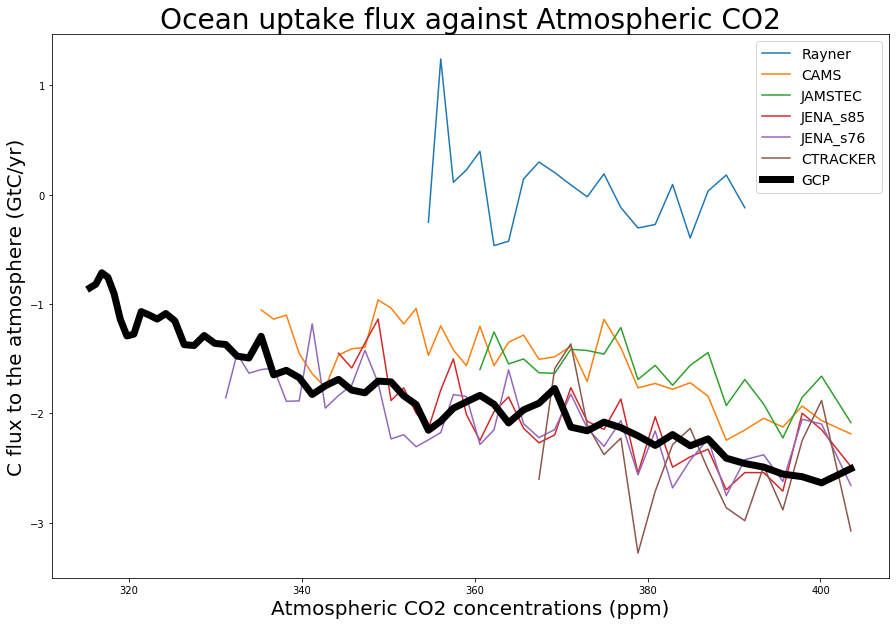

In [17]:
plt.figure(figsize=(15,10))

plt.plot(df.loc[1992:2012].CO2, Rayner.Earth_Ocean)
plt.plot(df.loc[1979:2017].CO2, CAMS.Earth_Ocean)
plt.plot(df.loc[1996:2017].CO2, JAMSTEC.Earth_Ocean)
plt.plot(df.loc[1985:2017].CO2, JENA_s85.Earth_Ocean)
plt.plot(df.loc[1976:2017].CO2, JENA_s76.Earth_Ocean)
plt.plot(df.loc[2000:2017].CO2, CTRACKER.Earth_Ocean)
plt.plot(df.CO2, df.ocean, linewidth=7, color='k')

plt.title("Ocean uptake flux against Atmospheric CO2", fontsize=28)
plt.xlabel("Atmospheric CO2 concentrations (ppm)", fontsize=20)
plt.ylabel("C flux to the atmosphere (GtC/yr)", fontsize=20)
plt.legend(["Rayner", "CAMS", "JAMSTEC", "JENA_s85", "JENA_s76", "CTRACKER", "GCP"], fontsize=14)

In [13]:
pickle.dump([df.CO2, df.ocean], open("./GCP_ocean.pik", "wb"))

# Global Uptake timeseries

In [4]:
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
GCB = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
GCB = -GCB
GCB.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,-0.852376,-0.516073,-0.860316
1960,-0.819017,-1.394030,-0.522722
1961,-0.714842,-0.605098,-1.213762
1962,-0.756709,-1.348349,-0.959605
1963,-0.904997,-0.877794,-1.355333


/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


0.7632484567409027

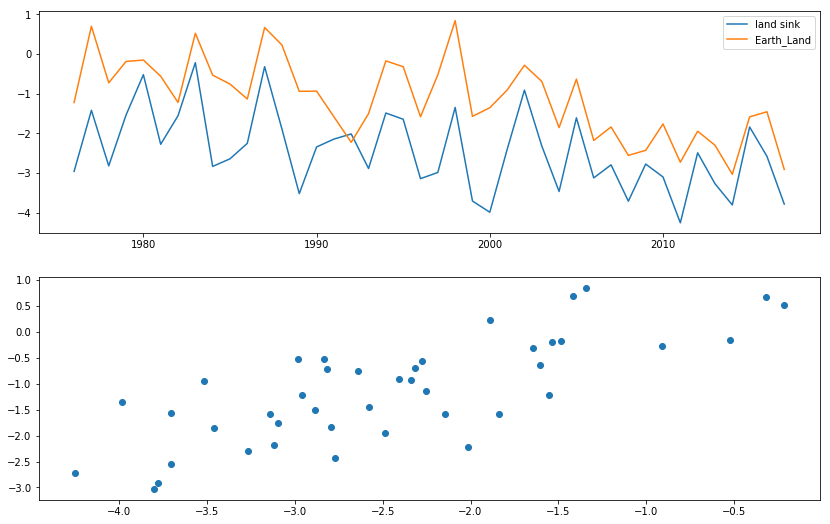

In [5]:
plt.figure(figsize=(14,9))
plt.subplot(211).plot(GCB.loc[1976:].index, GCB.loc[1976:]["land sink"])
plt.subplot(211).plot(GCB.loc[1976:].index, JENA_s76.Earth_Land)
plt.legend()
plt.subplot(212).scatter(GCB.loc[1976:]["land sink"], JENA_s76.Earth_Land)
stats.linregress(GCB.loc[1976:]["land sink"], JENA_s76.Earth_Land)[2]

Other things to do:
- Frequency correlation
- Cross-correlation
- Refer to stats course (sem 1) for more things to do

# Rolling gradient